## Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import corner
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, accuracy_score, roc_auc_score
from astroML.utils import completeness_contamination
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

%load_ext tensorboard

In [3]:
file = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')
file.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [4]:
cut = 10**4

det = file["det"][:cut]
M_tot = file["mtot"][:cut]
q = file["q"][:cut]
iota = file["iota"][:cut]
psi = file["psi"][:cut]
z = file["z"][:cut]
chi1 = np.array([file["chi1x"][:cut], file["chi1y"][:cut], file["chi1z"][:cut]]).T
chi1_mod = np.sqrt(np.sum(chi1**2, axis=1))
chi2 = np.array([file["chi2x"][:cut], file["chi2y"][:cut], file["chi2z"][:cut]]).T
chi2_mod = np.sqrt(np.sum(chi2**2, axis=1))

data = np.vstack([M_tot, q, iota, z, file["ra"][:cut], file["dec"][:cut], file["chi1x"][:cut], 
                  file["chi1y"][:cut], file["chi1z"][:cut], file["chi2x"][:cut], file["chi2y"][:cut], file["chi2z"][:cut], psi]).T

names = ["$M_{tot}$", "q", "$\iota$", "z", "RA", "DEC", "$\chi_1^x$", "$\chi_1^y$", "$\chi_1^z$", "$\chi_2^x$", "$\chi_2^y$", "$\chi_2^z$", "$\psi$"]

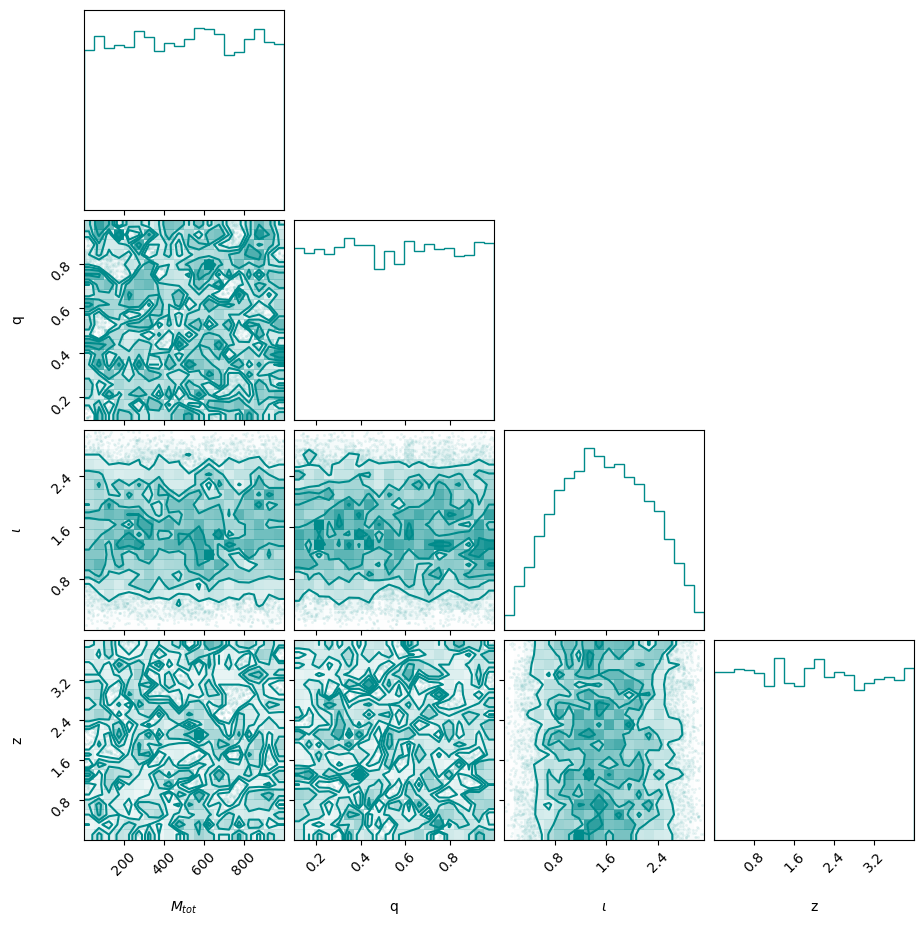

In [5]:
fig_corner = corner.corner(np.array([M_tot, q, iota, z]).T, labels=["$M_{tot}$", "q", "$\iota$", "z"], color="darkcyan")

In [6]:
train_X, test_X, train_y, test_y = train_test_split(data, det, train_size=0.75)

I fit the scaler on the train dataset only, then transform both train and test. This is done to prevent "information" from the test set to influence the fitting of the classifiers on the scaled train set (through the scaling): the test set must be completely unknown data

In [8]:
#Scale the data first

scaler = StandardScaler()
scaler.fit(train_X)
train_X_s = scaler.transform(train_X)
test_X_s = scaler.transform(test_X)

## Standard classifiers

In [10]:
def ComputeStats(train_X, train_y, test_X, test_y, clf, plot=False):
    clf.fit(train_X, train_y)

    fpr_train, tpr_train = [], []
    fpr_test, tpr_test = [], []

    for i in [(train_X, train_y, "Train set"), (test_X, test_y, "Test_set")]:
        X, y = i[0], i[1]

        pred = clf.predict(X)
        prob = clf.predict_proba(X)[:, 1]
               
        fpr, tpr, th = roc_curve(y, prob)
        comp, cont = completeness_contamination(pred, y)
        pre = precision_score(y, pred)
        acc = accuracy_score(y, pred)
        auc = roc_auc_score(y, prob)

        print(i[2] + ":")
        print("Completness = " + str(comp))
        print("Contamination = " + str(cont))
        print("Precision = " + str(pre))
        print("Accuracy = " + str(acc))
        print("AUC = " + str(auc))

        if i[2] == "Train set":
            fpr_train = fpr
            tpr_train = tpr
            print("\n")

        else:
            fpr_test = fpr
            tpr_test = tpr

        if plot:
            plt.figure()
            plt.plot(fpr, tpr)
            plt.title(i[2] + " ROC curve")
            plt.xlabel("False positive rate")
            plt.ylabel("True positive rate")
            plt.show()

    return fpr_test, tpr_test

### Decision tree

In [12]:
#Decision tree

cv = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), {"max_depth": np.arange(4, 8)}, cv=10)
cv.fit(train_X_s, train_y)
bd = cv.best_params_["max_depth"]
print("Best depth = " + str(bd))

fpr_dtc, tpr_dtc = ComputeStats(train_X_s, train_y, test_X_s, test_y, DecisionTreeClassifier(max_depth=bd, criterion="entropy"))

Best depth = 7
Train set:
Completness = 0.8663677130044843
Contamination = 0.11131554737810488
Precision = 0.8886844526218951
Accuracy = 0.964
AUC = 0.9925288038458973


Test_set:
Completness = 0.8213256484149856
Contamination = 0.17391304347826086
Precision = 0.8260869565217391
Accuracy = 0.9512
AUC = 0.9647519512348562


### Bagging classifier

In [14]:
#Bagging classifier

fpr_b, tpr_b = ComputeStats(train_X_s, train_y, test_X_s, test_y, BaggingClassifier(n_estimators=10))

Train set:
Completness = 0.9838565022421525
Contamination = 0.006340579710144928
Precision = 0.9936594202898551
Accuracy = 0.9966666666666667
AUC = 0.9999142468860944


Test_set:
Completness = 0.8097982708933718
Contamination = 0.11075949367088607
Precision = 0.8892405063291139
Accuracy = 0.9596
AUC = 0.9811134118869054


### Random forest classifier

In [16]:
#Random forest classifier

cv = GridSearchCV(RandomForestClassifier(criterion="entropy", n_jobs=-1), {"max_depth": np.arange(7, 10)}, cv=10, n_jobs=-1)
cv.fit(train_X_s, train_y)
bd = cv.best_params_["max_depth"]
print("Best depth = " + str(bd))

fpr_rf, tpr_rf = ComputeStats(train_X_s, train_y, test_X_s, test_y, RandomForestClassifier(max_depth=bd, criterion="entropy", n_jobs=-1))

Best depth = 9
Train set:
Completness = 0.8699551569506726
Contamination = 0.02512562814070352
Precision = 0.9748743718592965
Accuracy = 0.9773333333333334
AUC = 0.9978841946686987


Test_set:
Completness = 0.7809798270893372
Contamination = 0.11437908496732026
Precision = 0.8856209150326797
Accuracy = 0.9556
AUC = 0.9878876870421408


### Gradient boosting classifier

In [18]:
#Gradient boosting classifier

cv = GridSearchCV(GradientBoostingClassifier(), {"n_estimators": np.arange(100, 250, 50), "learning_rate": np.arange(0.1, 1, 0.3)}, cv=2, n_jobs=-1, verbose=4)
cv.fit(train_X_s, train_y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.4, 0.7]),
                         'n_estimators': array([100, 150, 200])},
             verbose=4)

In [19]:
bn = cv.best_params_["n_estimators"]
bl = cv.best_params_["learning_rate"]
print("Best number of estimators = " + str(bn))
print("Best learning rate = " + str(bl))

fpr_gb, tpr_gb = ComputeStats(train_X_s, train_y, test_X_s, test_y, GradientBoostingClassifier(n_estimators=bn, learning_rate=bl))

Best number of estimators = 150
Best learning rate = 0.1
Train set:
Completness = 0.915695067264574
Contamination = 0.04221388367729831
Precision = 0.9577861163227017
Accuracy = 0.9814666666666667
AUC = 0.9977455569562912


Test_set:
Completness = 0.8587896253602305
Contamination = 0.12352941176470589
Precision = 0.8764705882352941
Accuracy = 0.9636
AUC = 0.9921816753246927


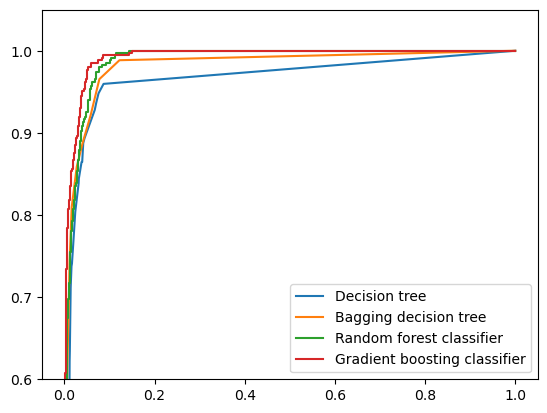

In [20]:
#Plot the ROC curves for each classifier

plt.figure()
plt.plot(fpr_dtc, tpr_dtc, label="Decision tree")
plt.plot(fpr_b, tpr_b, label="Bagging decision tree")
plt.plot(fpr_rf, tpr_rf, label="Random forest classifier")
plt.plot(fpr_gb, tpr_gb, label="Gradient boosting classifier")
plt.ylim(0.6)
plt.legend()

The random forest classifier and the gradient boosting classifier give similar results.

## Gradient boosting best threshold

Completeness = 0.9769452449567724
Contamination = 0.25165562913907286
Precision = 0.7483443708609272
Accuracy = 0.9512
Confusion matrix = 
[[2039    8]
 [ 114  339]]


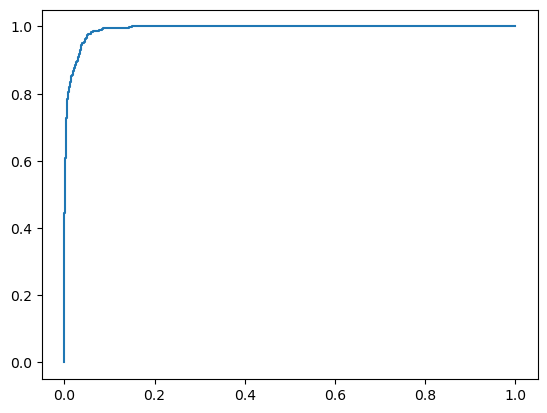

In [23]:
#Gradient boosting classifier
gbc = GradientBoostingClassifier(n_estimators=bn, learning_rate=bl)
gbc.fit(train_X_s, train_y)
prob_gbc = gbc.predict_proba(test_X_s)[:, 1]
fpr_gbc, tpr_gbc, th_gbc = roc_curve(test_y, prob_gbc)

plt.plot(fpr_gbc, tpr_gbc)

#Choose the threshold corresponding to the upper left part of the ROC curve
best_th_gbc = th_gbc[np.argmax(tpr_gbc - fpr_gbc)]
best_pred_gbc = np.array(prob_gbc >= best_th_gbc, dtype=int)

#Compute statistics

comp_gbc, cont_gbc = completeness_contamination(best_pred_gbc, test_y)
pre_gbc = precision_score(test_y, best_pred_gbc)
acc_gbc = accuracy_score(test_y, best_pred_gbc)
C_gbc = confusion_matrix(best_pred_gbc, test_y)

print("Completeness = " + str(comp_gbc))
print("Contamination = " + str(cont_gbc))
print("Precision = " + str(pre_gbc))
print("Accuracy = " + str(acc_gbc))
print("Confusion matrix = \n" + str(C_gbc))

## PCA

In [25]:
pca = PCA()
train_X_red = pca.fit_transform(train_X_s)
test_X_red = pca.transform(test_X_s)

Text(0, 0.5, 'Component 1')

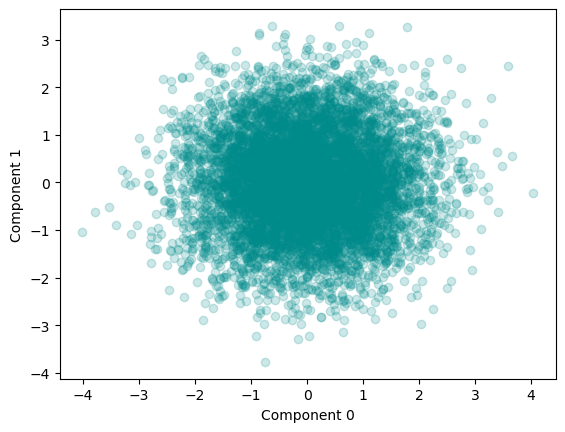

In [26]:
n_comp = pca.n_components_
evecs = pca.components_

plt.figure()
plt.scatter(train_X_red[:, 0], train_X_red[:, 1], color="darkcyan", alpha=0.2)
plt.xlabel("Component 0")
plt.ylabel("Component 1")

Seems like PCA can't really separate the components very well.

Text(0, 0.5, 'Feature importance')

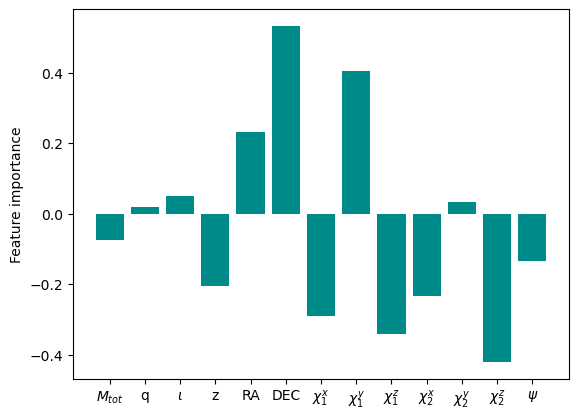

In [28]:
plt.figure()
plt.bar(names, evecs[0], color="darkcyan")
plt.ylabel("Feature importance")

Text(0, 0.5, 'Cumulative explained variance')

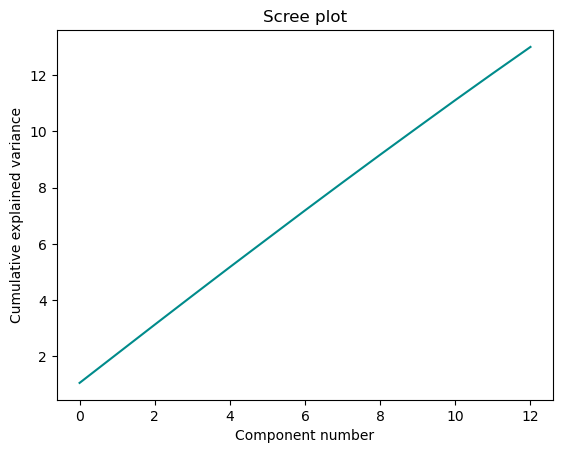

In [29]:
exp_var = np.cumsum(pca.explained_variance_)

plt.figure()
plt.plot(np.arange(0, n_comp), exp_var, color="darkcyan")
plt.title("Scree plot")
plt.xlabel("Component number")
plt.ylabel("Cumulative explained variance")

## Locally Linear Embedding

In [31]:
lle = LocallyLinearEmbedding(n_components=2, n_jobs=-1)
train_X_lle = lle.fit_transform(train_X_s)
test_X_lle = lle.transform(test_X_s)

Text(0, 0.5, 'Component 1')

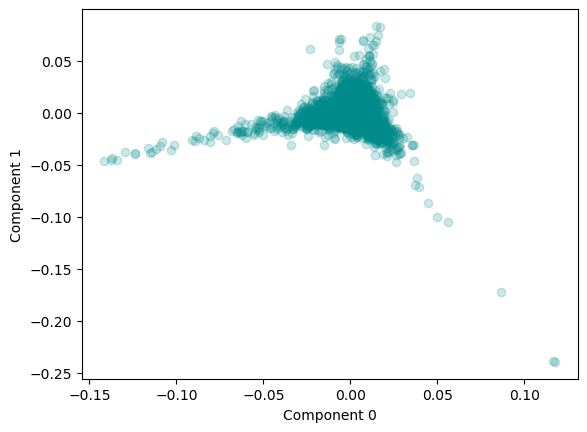

In [32]:
plt.figure()
plt.scatter(train_X_lle[:, 0], train_X_lle[:, 1], color="darkcyan", alpha=0.2)
plt.xlabel("Component 0")
plt.ylabel("Component 1")

In this case LLE is not much better than PCA to separate well all the components.

## Gradient boosting on PCA

In [35]:
cv_pca = GridSearchCV(GradientBoostingClassifier(), {"n_estimators": np.arange(100, 250, 50), "learning_rate": np.arange(0.1, 1, 0.3)}, cv=2, n_jobs=-1, verbose=4)
cv_pca.fit(train_X_red, train_y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.4, 0.7]),
                         'n_estimators': array([100, 150, 200])},
             verbose=4)

Best number of estimators = 200
Best learning rate = 0.7000000000000001
Completeness = 0.9711815561959655
Contamination = 0.4317032040472175
Precision = 0.5682967959527825
Accuracy = 0.8936
Confusion matrix = 
[[1897   10]
 [ 256  337]]


Text(0, 0.5, 'True positive rate')

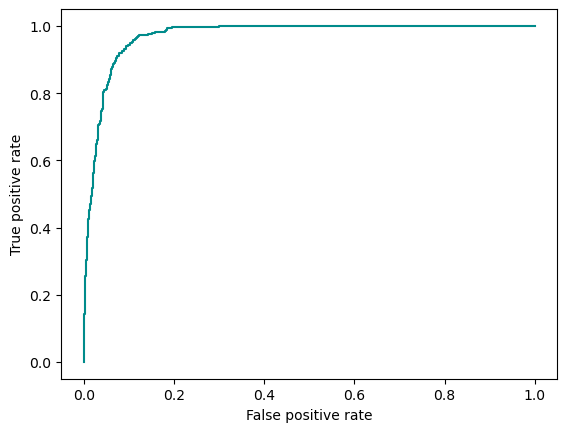

In [36]:
#Gradient boosting classifier

bn = cv_pca.best_params_["n_estimators"]
bl = cv_pca.best_params_["learning_rate"]
print("Best number of estimators = " + str(bn))
print("Best learning rate = " + str(bl))

gbc_pca = GradientBoostingClassifier(n_estimators=bn, learning_rate=bl)
gbc_pca.fit(train_X_red, train_y)
prob = gbc_pca.predict_proba(test_X_red)[:, 1]
fpr, tpr, th = roc_curve(test_y, prob)

#Choose the threshold corresponding to the upper left part of the ROC curve
best_th = th[np.argmax(tpr - fpr)]
best_pred = np.array(prob >= best_th, dtype=bool)

#Compute statistics

comp, cont = completeness_contamination(best_pred, test_y)
pre = precision_score(test_y, best_pred)
acc = accuracy_score(test_y, best_pred)
C = confusion_matrix(best_pred, test_y)

print("Completeness = " + str(comp))
print("Contamination = " + str(cont))
print("Precision = " + str(pre))
print("Accuracy = " + str(acc))
print("Confusion matrix = \n" + str(C))

#ROC curve

plt.figure()
plt.plot(fpr, tpr, color="darkcyan")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

## Gradient boosting on LLE

In [38]:
cv_lle = GridSearchCV(GradientBoostingClassifier(), {"n_estimators": np.arange(100, 250, 50), "learning_rate": np.arange(0.1, 1, 0.3)}, cv=5, n_jobs=-1, verbose=4)
cv_lle.fit(train_X_lle, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.4, 0.7]),
                         'n_estimators': array([100, 150, 200])},
             verbose=4)

Best number of estimators = 100
Best learning rate = 0.1
Completeness = 0.7118155619596542
Contamination = 0.7706592386258124
Precision = 0.22934076137418755
Accuracy = 0.628
Confusion matrix = 
[[1323  100]
 [ 830  247]]


Text(0, 0.5, 'True positive rate')

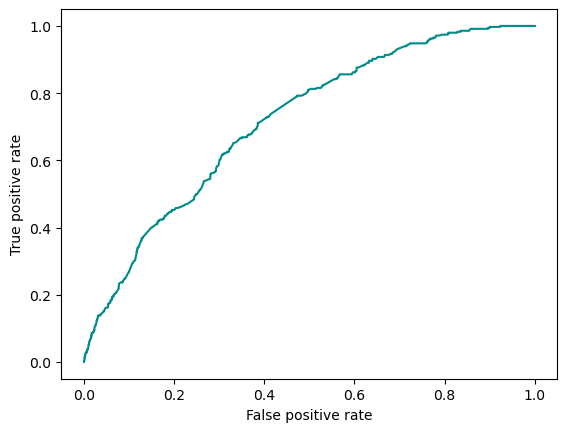

In [39]:
#Gradient boosting classifier

bn = cv_lle.best_params_["n_estimators"]
bl = cv_lle.best_params_["learning_rate"]
print("Best number of estimators = " + str(bn))
print("Best learning rate = " + str(bl))

gbc_lle = GradientBoostingClassifier(n_estimators=bn, learning_rate=bl)
gbc_lle.fit(train_X_lle, train_y)
prob = gbc_lle.predict_proba(test_X_lle)[:, 1]
fpr, tpr, th = roc_curve(test_y, prob)

#Choose the threshold corresponding to the upper left part of the ROC curve
best_th = th[np.argmax(tpr - fpr)]
best_pred = np.array(prob >= best_th, dtype=bool)

#Compute statistics

comp, cont = completeness_contamination(best_pred, test_y)
pre = precision_score(test_y, best_pred)
acc = accuracy_score(test_y, best_pred)
C = confusion_matrix(best_pred, test_y)

print("Completeness = " + str(comp))
print("Contamination = " + str(cont))
print("Precision = " + str(pre))
print("Accuracy = " + str(acc))
print("Confusion matrix = \n" + str(C))

#ROC curve

plt.figure()
plt.plot(fpr, tpr, color="darkcyan")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

The GBC has performed worse than on the original dataset on both PCA and LLE.

## Neural network

In [42]:
#Split the original test set into validation and test set for the NN

val_X_nn, test_X_nn, val_y_nn, test_y_nn = train_test_split(test_X_s, test_y, train_size=0.5)

In [43]:
HP_NUM_UNITS = hp.HParam("num_units", hp.Discrete([30, 50, 100]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.2, 0.5, 0.8]))

METRIC_ACCURACY = "accuracy"
METRIC_RECALL = "recall"

with tf.summary.create_file_writer("logs/hparam_tuning_GW").as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy"), hp.Metric(METRIC_RECALL, display_name="Recall")],
  )

In [44]:
#Define the model

def train_test_model(hparams):
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=train_X_s.shape[-1]),
        keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        keras.layers.Dropout(hparams[HP_DROPOUT]),
        keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        keras.layers.Dropout(hparams[HP_DROPOUT]),
        keras.layers.Dense(units=1, activation="sigmoid")
    ])
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), 
                  optimizer="adam", 
                  metrics=[keras.metrics.BinaryAccuracy(name="binary accuracy"), keras.metrics.Recall(name="recall")])
    
    fit = model.fit(train_X_s, train_y, epochs=3, validation_data=(val_X_nn, val_y_nn), use_multiprocessing=True)

    _, accuracy, recall = model.evaluate(test_X_nn, test_y_nn)
    
    return accuracy, recall

In [45]:
#Define the run function

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # Record the values used in this trial
      
    accuracy, recall = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    tf.summary.scalar(METRIC_RECALL, recall, step=1)

In [46]:
keras.backend.clear_session()

In [47]:
#Run the sessions to tune the hyperparameters

session_num = 0

for dropout_rate in HP_DROPOUT.domain.values:
    for num_units in HP_NUM_UNITS.domain.values:
        hparams = {HP_NUM_UNITS: num_units,
                  HP_DROPOUT: dropout_rate
                  }
        
        run_name = "run_" + str(session_num)
        print('--- Starting trial: ' + str(run_name))
        print({h.name: hparams[h] for h in hparams})
    
        run('logs/hparam_tuning_GW/' + run_name, hparams)
        session_num += 1

--- Starting trial: run_0
{'num_units': 30, 'dropout': 0.2}
Epoch 1/3
235/235 [==============================] - 3s 3ms/step - loss: 0.4065 - binary accuracy: 0.8216 - recall: 0.0735 - val_loss: 0.2317 - val_binary accuracy: 0.8952 - val_recall: 0.2805
Epoch 2/3
235/235 [==============================] - 0s 2ms/step - loss: 0.2406 - binary accuracy: 0.8868 - recall: 0.4404 - val_loss: 0.1616 - val_binary accuracy: 0.9280 - val_recall: 0.6463
Epoch 3/3
40/40 [==============================] - 0s 2ms/step - loss: 0.1656 - binary accuracy: 0.9216 - recall: 0.7158
--- Starting trial: run_1
{'num_units': 50, 'dropout': 0.2}
Epoch 1/3
235/235 [==============================] - 1s 3ms/step - loss: 0.3306 - binary accuracy: 0.8495 - recall: 0.1901 - val_loss: 0.1819 - val_binary accuracy: 0.9208 - val_recall: 0.5915
Epoch 2/3
235/235 [==============================] - 0s 2ms/step - loss: 0.2017 - binary accuracy: 0.9060 - recall: 0.6233 - val_loss: 0.1394 - val_binary accuracy: 0.9392 - val_re

In [48]:
%tensorboard --logdir logs/hparam_tuning_GW

In [92]:
#Best accuracy model

best_num_units = 100
best_dropout = 0.2

#Best recall model

# best_num_units = 100
# best_dropout = 0.2

In [94]:
keras.backend.clear_session()

In [95]:
model_nn = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=train_X_s.shape[-1]),
    keras.layers.Dense(best_num_units, activation="relu"),
    keras.layers.Dropout(best_dropout),
    keras.layers.Dense(best_num_units, activation="relu"),
    keras.layers.Dropout(best_dropout),
    keras.layers.Dense(units=1, activation="sigmoid")
])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


In [96]:
model_nn.compile(loss=keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall()])
model_nn.fit(train_X_s, train_y, epochs=20, validation_data=(val_X_nn, val_y_nn), use_multiprocessing=True)

Epoch 1/20
235/235 [==============================] - 2s 3ms/step - loss: 0.2741 - binary_accuracy: 0.8801 - recall: 0.3507 - val_loss: 0.1603 - val_binary_accuracy: 0.9304 - val_recall: 0.8537
Epoch 2/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1736 - binary_accuracy: 0.9205 - recall: 0.7256 - val_loss: 0.1273 - val_binary_accuracy: 0.9416 - val_recall: 0.8659
Epoch 3/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1515 - binary_accuracy: 0.9304 - recall: 0.7641 - val_loss: 0.1119 - val_binary_accuracy: 0.9512 - val_recall: 0.8598
Epoch 4/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1315 - binary_accuracy: 0.9387 - recall: 0.8027 - val_loss: 0.1039 - val_binary_accuracy: 0.9552 - val_recall: 0.8720
Epoch 5/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1266 - binary_accuracy: 0.9432 - recall: 0.8206 - val_loss: 0.1016 - val_binary_accuracy: 0.9536 - val_recall: 0.8780
Epoch 6/20
235/235 [==========

40/40 [==============================] - 0s 2ms/step
Neural network:
Completeness = 0.9726775956284153
Contamination = 0.27049180327868855


GBC:
Completeness = 0.9769452449567724
Contamination = 0.25165562913907286


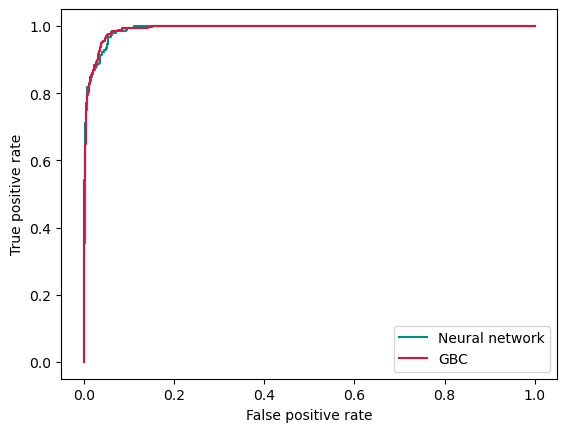

In [97]:
nn_prob = model_nn.predict(test_X_nn)

fpr_nn, tpr_nn, th_nn = roc_curve(test_y_nn, nn_prob)
best_th_nn = th_nn[np.argmax(tpr_nn - fpr_nn)]
nn_pred = np.array(nn_prob.flatten() > best_th_nn, dtype=int)

comp_nn, cont_nn = completeness_contamination(nn_pred, test_y_nn)

print("Neural network:")
print("Completeness = " + str(comp_nn))
print("Contamination = " + str(cont_nn))
print("\n")
print("GBC:")
print("Completeness = " + str(comp_gbc))
print("Contamination = " + str(cont_gbc))

plt.figure()
plt.plot(fpr_nn, tpr_nn, color="darkcyan", label="Neural network")
plt.plot(fpr_gbc, tpr_gbc, color="crimson", label="GBC")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()

The performance between NN and GBC is similar, at least for a simple NN like the one used.